# Shadow removal with luminance clustering and color clustering

In [1]:
import numpy as np
import imageio
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Adaptive Denoising
def adaptive_denoising(g, k, gamma, denoise_mode, iterations=1):
    # calculate the center of kernel
    a = k//2

    # create a zero matrix to fill with denoising result
    r = np.zeros(g.shape)
    
    for i in range(iterations):
        # declaration of image dispersion measure, local dispersion measure and centrality measure
        gdisp = 0.0
        ldisp = 0.0
        centr = 0.0

        # compute the estimation of the image global dispersion in a determined subregion of the image accordig to the assignment description
        subregion = g[0:(g.shape[0]//6), 0:(g.shape[1]//6)]
        if(denoise_mode == "average"):
            gdisp = np.std(subregion)
        if(denoise_mode == "robust"):
            q1, c, q2 = np.percentile(subregion, [25, 50, 75])
            gdisp = q2 - q1

        # "If the dispersion measure computed for some image is 0, then manually set it to 1"
        if(gdisp == 0):
            gdisp = 1

        # loop to run all over the image and denoise it
        for x in range(g.shape[0]):
            for y in range(g.shape[1]):
                # if running at the border of the image, when the filter kernel exceeds the limits of the image
                # then the resulting value is the copy of original image's pixel.
                if(x<a or x>(g.shape[0]-a) or y<a or y>(g.shape[1]-a)):
                    r[x,y] = g[x,y]

                # else compute the filter
                else:
                    # Sx is the image region, kernel size, to be filtered
                    Sx = g[x-a:(x+a+1), y-a:(y+a+1)]

                    # compute the local dispersion and centrality measure, according to denoise mode (average/robust)
                    if(denoise_mode == "average"):
                        # if denoise mode is average, dispersion is standard deviation and the centrality is the mean of region Sx
                        ldisp = np.std(Sx)
                        centr = np.mean(Sx)
                    elif(denoise_mode == "robust"):
                        # if denoise mode is robust, dispersion is interquartile range and the centrality is the median of region Sx
                        q1, centr, q2 = np.percentile(Sx, [25, 50, 75])
                        ldisp = q2 - q1

                    # "If during the denoising step, any local dispersion measure is 0, then set it so that local dispersion = global dispersion"
                    if(ldisp == 0):
                        ldisp = gdisp

                    # formula of adaptive denoising
                    r[x,y] = int(g[x,y] - gamma*(gdisp/ldisp)*(g[x,y]-centr))
    
    return r

In [3]:
# readjustment of range of values
def range_adjustment(img,minvalue=0,maxvalue=255):
    try:
        layers = img.shape[2]
    except:
        layers = 1
    
    img_u8 = np.zeros(img.shape, dtype=np.uint8)
    if(layers > 1):
        for z in range(layers):
            currmin = np.min(img[:,:,z])
            currmax = np.max(img[:,:,z])
            for x in range(img.shape[0]):
                for y in range(img.shape[1]):
                    img_u8[x,y,z] = ((img[x,y,z]-currmin)*(maxvalue - minvalue)//(currmax - currmin)) + minvalue
    else:
        currmin = np.min(img)
        currmax = np.max(img)
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                img_u8[x,y] = ((img[x,y]-currmin)*(maxvalue - minvalue)//(currmax - currmin)) + minvalue
    
    return img_u8 

In [4]:
img = imageio.imread("../images/shadow5.jpg")
for i in range(3):
    img[:,:,i] = adaptive_denoising(img[:,:,i],3,0.005,"robust")

In [5]:
# find the closest cluster to the example pixel
def closest_cluster(centroids, example):
    # calculate the euclidian distances of the example from all centroids
    distances = np.linalg.norm(np.subtract(centroids, example),axis=1)

    # return the cluster number in which there is the min distance value
    return (np.where(distances == np.min(distances))[0][0] + 1)

In [6]:
# after each iteration, the centroids coordinates are updated
def update_centroids(labeled_dataset, dataset, centroids):
    # for each centroid, compute the average values of all respective pixels attributes
    for c in range(centroids.shape[0]):
        # get all pixels that belongs to 'c' cluster
        cluster = dataset[np.where(labeled_dataset == c+1)]

        # compute the average of attributes values
        if(cluster.shape[0] != 0):
            centroids[c] = np.mean(cluster,axis=0)

    return centroids

In [7]:
# function to run the k-means routine in 'n' iterations
def kmeans_routine(dataset, centroids, k, n):
    r=centroids.shape[1]
    # create the frame for labeling the image
    label_img = np.zeros((dataset.shape[0],dataset.shape[1]), dtype=np.uint8)

    # loop to repeat 'n' times the iteration
    for iteration in range(n):
        # loops to run all dataset, labeling the objects according to centroids similarity
        for x in range(dataset.shape[0]):
            for y in range(dataset.shape[1]):
                try:
                    if(np.sum(dataset[x,y][:3]) == 0):
                        label_img[x,y] = 0
                    else:
                        # collect an example object from dataset to be labeled
                        example = dataset[x,y]

                        # according to similarity, select the cluster in which the example belongs
                        cluster = closest_cluster(centroids, example)
                        # set the label_img pixel value to cluster's number
                        label_img[x,y] = cluster
                except:
                    if(np.sum(dataset[x,y]) == 0):
                        label_img[x,y] = 0
                    else:
                        # collect an example object from dataset to be labeled
                        example = dataset[x,y]

                        # according to similarity, select the cluster in which the example belongs
                        cluster = closest_cluster(centroids, example)
                        # set the label_img pixel value to cluster's number
                        label_img[x,y] = cluster

        # update the centroids by calculating the average of attributes of each formed clusters
        centroids = update_centroids(label_img, dataset, centroids)
        
    return label_img

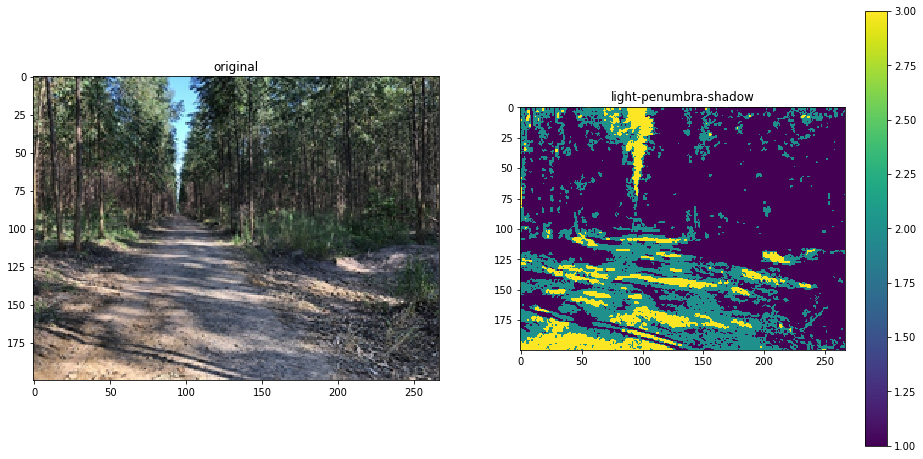

In [8]:
luminance_dataset = 0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]

# luminance_centroids = np.array([[np.min(luminance_dataset)], [np.max(luminance_dataset)]])
luminance_centroids = np.array([[np.min(luminance_dataset)], 
                                [np.max(luminance_dataset)*2/3], 
                                [np.max(luminance_dataset)]])

# lus = kmeans_routine(luminance_dataset, luminance_centroids, 2, 1)
lus = kmeans_routine(luminance_dataset, luminance_centroids, luminance_centroids.shape[0], 5)

lus = adaptive_denoising(lus, 3, 0.005, "robust",1)

plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(img); plt.title("original")
plt.subplot(122); plt.imshow(lus); plt.title("light-penumbra-shadow"); plt.colorbar()

In [9]:
lit_mask = np.zeros((img.shape[0], img.shape[1]))
penumbra_mask = np.zeros((img.shape[0], img.shape[1]))
umbra_mask = np.zeros((img.shape[0], img.shape[1]))

lit_mask[np.where(lus==3)] = 1
penumbra_mask[np.where(lus==2)] = 1
umbra_mask[np.where(lus==1)] = 1

lit_img = np.zeros(img.shape, dtype=np.uint8)
penumbra_img = np.zeros(img.shape, dtype=np.uint8)
umbra_img = np.zeros(img.shape, dtype=np.uint8)
for i in range(3):
    lit_img[:,:,i] = np.multiply(lit_mask,img[:,:,i])
    penumbra_img[:,:,i] = np.multiply(penumbra_mask,img[:,:,i])
    umbra_img[:,:,i] = np.multiply(umbra_mask,img[:,:,i])

In [10]:
lit_clusters_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

indx = np.arange(0, lit_img.shape[1])
indy = np.arange(0, lit_img.shape[0])
x,y = np.meshgrid(indx, indy)
lit_dataset = np.dstack((lit_img, x, y))
# lit_dataset = lit_img

# lit_centroids=np.array([[255,0,0],
#                          [0,255,0],
#                          [0,0,255]])
lit_centroids=np.array([[255,0,0,img.shape[1]//2,img.shape[0]-1],
                         [0,255,0,img.shape[1]//2,img.shape[0]//2],
                         [0,0,255,img.shape[1]//2,0]])

lit_clusters_mask = kmeans_routine(lit_dataset, lit_centroids, 3, 1)

In [11]:
penumbra_clusters_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

penumbra_dataset = penumbra_img

penumbra_centroids=np.array([[255,0,0],
                         [0,255,0],
                         [0,0,255]])

penumbra_clusters_mask = kmeans_routine(penumbra_dataset, penumbra_centroids, 3, 1)

In [12]:
umbra_clusters_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

umbra_dataset = umbra_img

umbra_centroids=np.array([[255,0,0],
                         [0,255,0],
                         [0,0,255]])

umbra_clusters_mask = kmeans_routine(umbra_dataset, umbra_centroids, 3, 1)

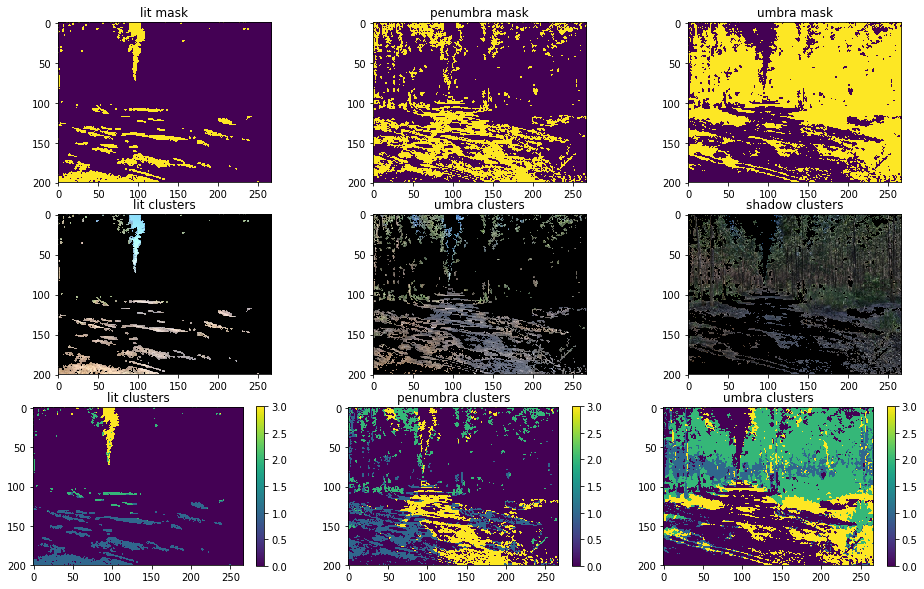

In [13]:
plt.figure(figsize=(16,10))
plt.subplot(331);plt.imshow(lit_mask);plt.title("lit mask")
plt.subplot(332);plt.imshow(penumbra_mask);plt.title("penumbra mask")
plt.subplot(333);plt.imshow(umbra_mask);plt.title("umbra mask")

plt.subplot(334);plt.imshow(lit_img);plt.title("lit clusters")
plt.subplot(335);plt.imshow(penumbra_img);plt.title("umbra clusters")
plt.subplot(336);plt.imshow(umbra_img);plt.title("shadow clusters")

plt.subplot(337);plt.imshow(lit_clusters_mask);plt.title("lit clusters");plt.colorbar()
plt.subplot(338);plt.imshow(penumbra_clusters_mask);plt.title("penumbra clusters");plt.colorbar()
plt.subplot(339);plt.imshow(umbra_clusters_mask);plt.title("umbra clusters");plt.colorbar()

In [14]:
lit_road = np.zeros(lit_clusters_mask.shape, dtype=np.uint8)
lit_road[np.where(lit_clusters_mask == 1)] = 1
lit_road_img = np.zeros(img.shape, dtype = np.uint8)
for i in range(3):
    lit_road_img[:,:,i] = np.multiply(img[:,:,i],lit_road)

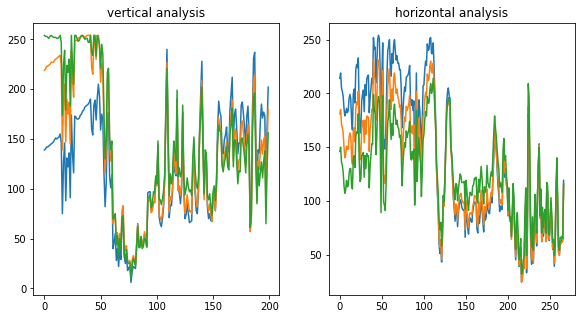

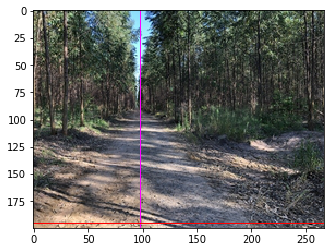

In [23]:
vline = 98
hline = -5
plt.figure(figsize=(15,5))
plt.subplot(131); plt.plot(img[:,vline,:]); plt.title("vertical analysis"); #plt.plot(np.ones(200)*100.5)
plt.subplot(132); plt.plot(img[hline,:,:]); plt.title("horizontal analysis")


img_copy = np.copy(img)
img_copy[:,vline] = [255,0,255]
img_copy[hline,:] = [255,0,0]
plt.figure()
plt.imshow(img_copy)

In [16]:
def remove_shadow(img, mask, ref_mask):
    mask_coordinates = np.where(mask==1)
    ref_coordinates = np.where(ref_mask==1)

    # loop for each color layer
    for c in range(3):
        refmean = np.average(img[np.where(ref_mask==1)][:,c])
        refstd = np.std(img[np.where(ref_mask==1)][:,c])
#         refmin = refmean - 2*refstd
#         refmax = refmean + 2*refstd
#         refmin = np.mean((np.min(img[ref_coordinates][:,c]),(refmean - refstd)))
#         refmax = np.mean((np.max(img[ref_coordinates][:,c]),(refmean + refstd)))
        refmin = np.min(img[ref_coordinates][:,c])
        refmax = np.max(img[ref_coordinates][:,c])
        
        maskmean = np.average(img[np.where(mask==1)][:,c])
        maskmin = np.min(img[mask_coordinates][:,c])
        maskmax = np.max(img[mask_coordinates][:,c])
        
        diff = refmean - maskmean

        for i in range(mask_coordinates[0].shape[0]):
            x,y,z=mask_coordinates[0][i],mask_coordinates[1][i],c
            img[x,y,z]=((float(img[x,y,z])-maskmin)*(refmax - refmin)/(maskmax - maskmin)) + refmin
#             img[x,y,z]+= (diff + refstd)
        
    return img

In [24]:
img_copy = np.copy(img)

penumbra_blue_mask = np.zeros(penumbra_clusters_mask.shape, dtype=np.uint8)
penumbra_blue_mask[np.where(penumbra_clusters_mask == 3)] = 1

penumbra_red_mask = np.zeros(penumbra_clusters_mask.shape, dtype=np.uint8)
penumbra_red_mask[np.where(penumbra_clusters_mask == 1)] = 1

umbra_blue_mask = np.zeros(umbra_clusters_mask.shape, dtype=np.uint8)
umbra_blue_mask[np.where(umbra_clusters_mask == 3)] = 1

umbra_red_mask = np.zeros(umbra_clusters_mask.shape, dtype=np.uint8)
umbra_red_mask[np.where(umbra_clusters_mask == 1)] = 1

lit_red_mask = np.zeros(lit_clusters_mask.shape, dtype=np.uint8)
lit_red_mask[np.where(lit_clusters_mask==1)] = 1

# equalize blue penumbra region with red penumbra region
img_copy = remove_shadow(img_copy, penumbra_blue_mask, penumbra_red_mask)

# equalize blue umbra region with red umbra region
img_copy = remove_shadow(img_copy, umbra_blue_mask, penumbra_red_mask)

# remove umbra on road region
umbra_road_mask = umbra_blue_mask

img_copy = remove_shadow(img_copy, umbra_road_mask, lit_red_mask)

# remove umbra on woods
umbra_woods_mask = umbra_red_mask
img_copy = remove_shadow(img_copy, umbra_woods_mask, penumbra_blue_mask)

# remove penumbra on road region
penumbra_road_mask = penumbra_blue_mask + penumbra_red_mask

img_copy = remove_shadow(img_copy, penumbra_road_mask, lit_red_mask)

# equalize green penumbra region
penumbra_green_mask = np.zeros(penumbra_clusters_mask.shape, dtype=np.uint8)
penumbra_green_mask[np.where(penumbra_clusters_mask == 2)] = 1

umbra_green_mask = np.zeros(umbra_clusters_mask.shape, dtype=np.uint8)
umbra_green_mask[np.where(umbra_clusters_mask == 2)] = 1

lit_green_mask = np.zeros(lit_clusters_mask.shape, dtype=np.uint8)
lit_green_mask[np.where(lit_clusters_mask == 2)] = 1

img_copy = remove_shadow(img_copy, penumbra_green_mask, lit_green_mask)
img_copy = remove_shadow(img_copy, umbra_green_mask, penumbra_green_mask)

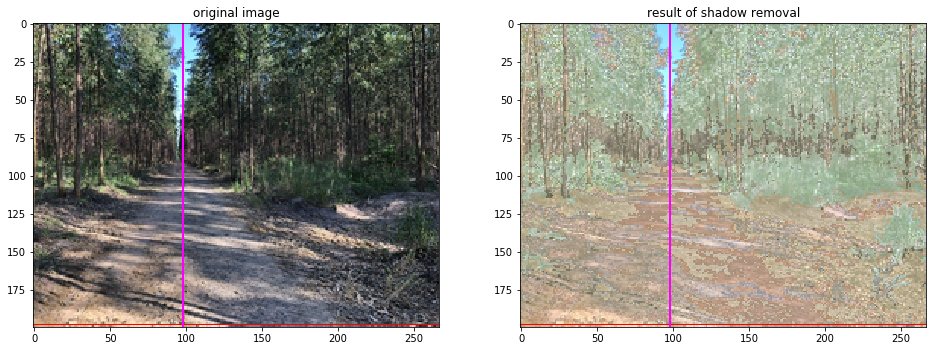

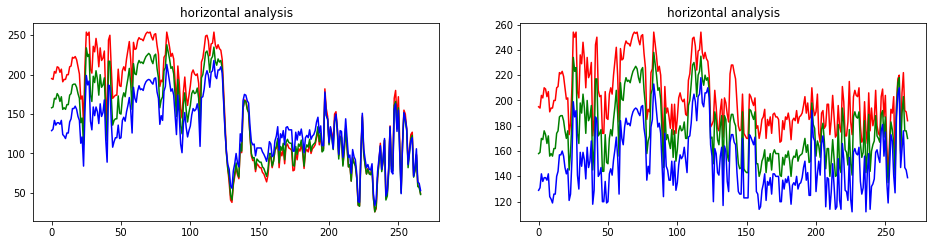

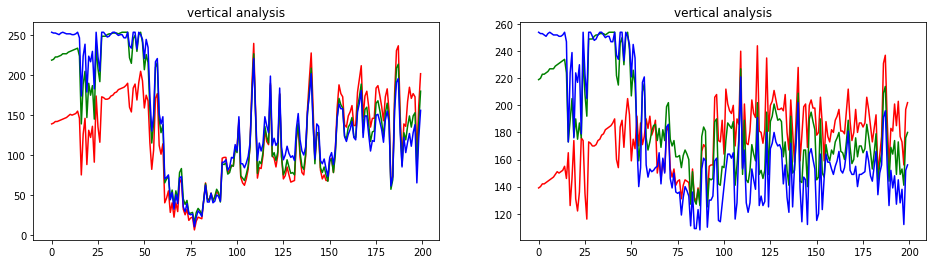

In [26]:
vline = 98
hline = -2
original = np.copy(img)
result = np.copy(img_copy)
original[hline,:] = [255,0,0]
result[hline,:] = [255,0,0]
original[:,vline] = [255,0,255]
result[:,vline] = [255,0,255]

plt.figure(figsize=(16,16))
plt.subplot(221);plt.imshow(original);plt.title("original image")
plt.subplot(222);plt.imshow(result); plt.title("result of shadow removal")
plt.figure(figsize=(16,8))
plt.subplot(223);plt.title("horizontal analysis")
plt.plot(img[hline,:,0],'r');plt.plot(img[hline,:,1],'g');plt.plot(img[hline,:,2],'b')
plt.subplot(224); plt.title("horizontal analysis")
plt.plot(img_copy[hline,:,0],'r');plt.plot(img_copy[hline,:,1],'g');plt.plot(img_copy[hline,:,2],'b')
plt.figure(figsize=(16,4))
plt.subplot(121);plt.title("vertical analysis")
plt.plot(img[:,vline,0],'r');plt.plot(img[:,vline,1],'g');plt.plot(img[:,vline,2],'b')
plt.subplot(122); plt.title("vertical analysis")
plt.plot(img_copy[:,vline,0],'r');plt.plot(img_copy[:,vline,1],'g');plt.plot(img_copy[:,vline,2],'b')